# Processing the DISEASES database of disease-gene associations

+ [publication](http://dx.doi.org/10.1016/j.ymeth.2014.11.020)
+ [website](http://diseases.jensenlab.org/Search)

In [1]:
# # Download DISEASES data files
# base_url = 'http://download.jensenlab.org/'
# filenames = [
#     'human_disease_integrated_full.tsv',
#     'human_disease_textmining_full.tsv',
#     'human_disease_knowledge_full.tsv',
#     'human_disease_experiments_full.tsv',
# ]

# for filename in filenames:
#     ! wget --no-verbose --directory-prefix download/ {base_url}/{filename}
#     ! gzip -f download/{filename}

In [2]:
# # Download STRING ensembl protein to entrez gene mapping
# url = 'ftp://string-db.org/STRING/9.1/mapping_files/Entrez_mappings/entrez_gene_id.vs.string.v9.05.28122012.txt'
# ! wget --no-verbose --timestamping --directory-prefix download/ {url}

In [3]:
import gzip

import pandas
import numpy
import matplotlib.pyplot
import seaborn

%matplotlib inline

In [4]:
def meta_score(scores):
    """
    Combines scores, which range form 0 to 5, into a single
    integrated score. Learn more at http://thinklab.com/d/91#7
    """
    scores = numpy.array(scores, dtype='float')
    probs = scores / 5
    prob = 1 - numpy.prod(1 - probs)
    score = 5 * prob
    return score

## Read terminologies

In [5]:
# Read entrez genes
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/6e133f9ef8ce51a4c5387e58a6cc97564a66cec8/data/genes-human.tsv'
entrez_df = pandas.read_table(url)    
entrez_df = entrez_df[['GeneID', 'Symbol']].rename(columns={'GeneID': 'entrez_gene_id', 'Symbol': 'gene_symbol'})
entrez_df.head(2)

,entrez_gene_id,gene_symbol
0,1,A1BG
1,2,A2M


## Read mappings

In [6]:
# Read Ensembl protein to Entrez Gene mappings
entrez_map_df = pandas.read_table('download/entrez_gene_id.vs.string.v9.05.28122012.txt')
entrez_map_df.columns = 'entrez_gene_id', 'ensembl_protein_id'
entrez_map_df.ensembl_protein_id = entrez_map_df.ensembl_protein_id.map(lambda x: x.split('.')[1])

In [7]:
# DO Slim nodes to subsumed nodes
url = 'https://raw.githubusercontent.com/dhimmel/disease-ontology/72614ade9f1cc5a5317b8f6836e1e464b31d5587/data/slim-terms-prop.tsv'
doslim_prop_df = pandas.read_table(url)
doslim_prop_df = doslim_prop_df.rename(columns={'subsumed_id': 'doid_id'})
doslim_prop_df = doslim_prop_df[['slim_id', 'slim_name', 'doid_id', 'min_distance']]
doslim_prop_df.head(2)

,slim_id,slim_name,doid_id,min_distance
0,DOID:0050156,idiopathic pulmonary fibrosis,DOID:0050156,0
1,DOID:0050425,restless legs syndrome,DOID:0050425,0


In [8]:
# Disease Ontology terms and names
url = 'https://raw.githubusercontent.com/dhimmel/disease-ontology/72614ade9f1cc5a5317b8f6836e1e464b31d5587/data/term-names.tsv'
doid_df = pandas.read_table(url).query("type == 'name'")
doid_df = doid_df.drop('type', 1).rename(columns={'doid': 'doid_id', 'name': 'doid_name'})
doid_df.head(2)

,doid_id,doid_name
0,DOID:9888,alternating esotropia
1,DOID:3389,Papillon-Lefevre disease


## text mining channel

In [9]:
column_names = ['ensembl_protein_id', 'gene_symbol', 'doid_id', 'doid_name', 'z-score', 'score', 'url']
text_df = pandas.read_table('download/human_disease_textmining_full.tsv.gz', names=column_names)
text_df.head(2)

,ensembl_protein_id,gene_symbol,doid_id,doid_name,z-score,score,url
0,5S_rRNA,5S_rRNA,DOID:0050290,Trichosporonosis,5.707,2.9,http://diseases.jensenlab.org/Entity?documents...
1,5S_rRNA,5S_rRNA,DOID:13382,Megaloblastic anemia,5.226,2.6,http://diseases.jensenlab.org/Entity?documents...


In [10]:
text_df = entrez_map_df.merge(text_df)
text_df = text_df.groupby(['entrez_gene_id', 'doid_id'])['score'].mean().reset_index()
text_df.head(2)

,entrez_gene_id,doid_id,score
0,1,DOID:0014667,0.8
1,1,DOID:0050117,0.9


## experiment channel

In [11]:
column_names = ['ensembl_protein_id', 'gene_symbol', 'doid_id', 'doid_name', 'source', 'evidence', 'score']
experiment_df = pandas.read_table('download/human_disease_experiments_full.tsv.gz', names=column_names)
experiment_df.head(2)

,ensembl_protein_id,gene_symbol,doid_id,doid_name,source,evidence,score
0,ENSP00000000412,M6PR,DOID:1289,Neurodegenerative disease,DistiLD,p-value = 5e-14,2
1,ENSP00000000412,M6PR,DOID:2377,Multiple sclerosis,DistiLD,p-value = 5e-14,2


In [12]:
cosmic_df = experiment_df.query("source=='COSMIC'")
cosmic_df = entrez_map_df.merge(cosmic_df)
cosmic_df = cosmic_df.groupby(['entrez_gene_id', 'doid_id'])['score'].mean().reset_index()

distild_df = experiment_df.query("source=='DistiLD'")
distild_df = entrez_map_df.merge(distild_df)
distild_df = distild_df.groupby(['entrez_gene_id', 'doid_id'])['score'].mean().reset_index()

## knowledge channel

In [13]:
column_names = ['ensembl_protein_id', 'gene_symbol', 'doid_id', 'doid_name', 'source', 'evidence', 'score']
knowledge_df = pandas.read_table('download/human_disease_knowledge_full.tsv.gz', names=column_names)
knowledge_df.head(2)

,ensembl_protein_id,gene_symbol,doid_id,doid_name,source,evidence,score
0,ENSP00000001146,CYP26B1,DOID:0080001,Bone disease,UniProtKB-KW,CURATED,4
1,ENSP00000001146,CYP26B1,DOID:0080006,Bone development disease,UniProtKB-KW,CURATED,4


In [14]:
# Combine UniProtKB and GHR evidence
knowledge_df = knowledge_df.groupby(['ensembl_protein_id', 'doid_id'])['score'].agg(meta_score).reset_index()
knowledge_df.head(2)

,ensembl_protein_id,doid_id,score
0,ENSP00000001146,DOID:0080001,4
1,ENSP00000001146,DOID:0080006,4


In [15]:
# Convert to entrez genes
knowledge_df = entrez_map_df.merge(knowledge_df)
knowledge_df = knowledge_df.groupby(['entrez_gene_id', 'doid_id'])['score'].mean().reset_index()
knowledge_df.head(2)

,entrez_gene_id,doid_id,score
0,16,DOID:10595,5
1,16,DOID:1289,4


## integrated channel

In [16]:
# Read integrated dataset
column_names = ['ensembl_protein_id', 'gene_symbol', 'doid_id', 'doid_name', 'score']
integrated_df = pandas.read_table('download/human_disease_integrated_full.tsv.gz', names=column_names)
integrated_df.head(2)

,ensembl_protein_id,gene_symbol,doid_id,doid_name,score
0,5S_rRNA,5S_rRNA,DOID:0050290,Trichosporonosis,2.9
1,5S_rRNA,5S_rRNA,DOID:13382,Megaloblastic anemia,2.6


In [17]:
integrated_df = entrez_map_df.merge(integrated_df)
integrated_df = integrated_df.groupby(['entrez_gene_id', 'doid_id'])['score'].mean().reset_index()
integrated_df.head(2)

,entrez_gene_id,doid_id,score
0,1,DOID:0014667,0.8
1,1,DOID:0050117,0.9


## compute integrated score excluding DistiLD

In [18]:
integrated_no_distild_df = pandas.concat([text_df, knowledge_df, cosmic_df])
integrated_no_distild_df.groupby(['entrez_gene_id', 'doid_id'])['score'].agg(meta_score).reset_index()
integrated_no_distild_df.head(2)

,entrez_gene_id,doid_id,score
0,1,DOID:0014667,0.8
1,1,DOID:0050117,0.9


## merge all channels

In [19]:
renames = [
    (text_df, 'text'),
    (knowledge_df, 'knowledge'),
    (cosmic_df, 'cosmic'),
    (distild_df, 'distild'),
    (integrated_no_distild_df, 'integrated_no_distild'),
    (integrated_df, 'integrated'),
]

# rename score columns to be unique
for df, name in renames:
    df.rename(columns={'score': 'score_{}'.format(name)}, inplace=True)

# merge all dataframes
dfs = [df for df, name in renames]
master_df = dfs.pop(0)
for df in dfs:
    master_df = master_df.merge(df, how='outer')

# convert Entrez Gene IDs to ints (pandas gotcha)
master_df.entrez_gene_id = master_df.entrez_gene_id.astype(int)

In [20]:
# add gene symbols and disease names
master_df = doid_df.merge(entrez_df.merge(master_df))
master_df.head(2)

,doid_id,doid_name,entrez_gene_id,gene_symbol,score_text,score_knowledge,score_cosmic,score_distild,score_integrated_no_distild,score_integrated
0,DOID:9888,alternating esotropia,1123,CHN1,1.9,NaN,NaN,NaN,1.9,1.9
1,DOID:3389,Papillon-Lefevre disease,1075,CTSC,2.8,NaN,NaN,NaN,2.8,2.8


In [21]:
# save a gzipped tsv
with gzip.open('data/merged.tsv.gz', 'wt') as write_file:
    master_df.to_csv(write_file, sep='\t', index=False, float_format='%.2g')

## score visualization

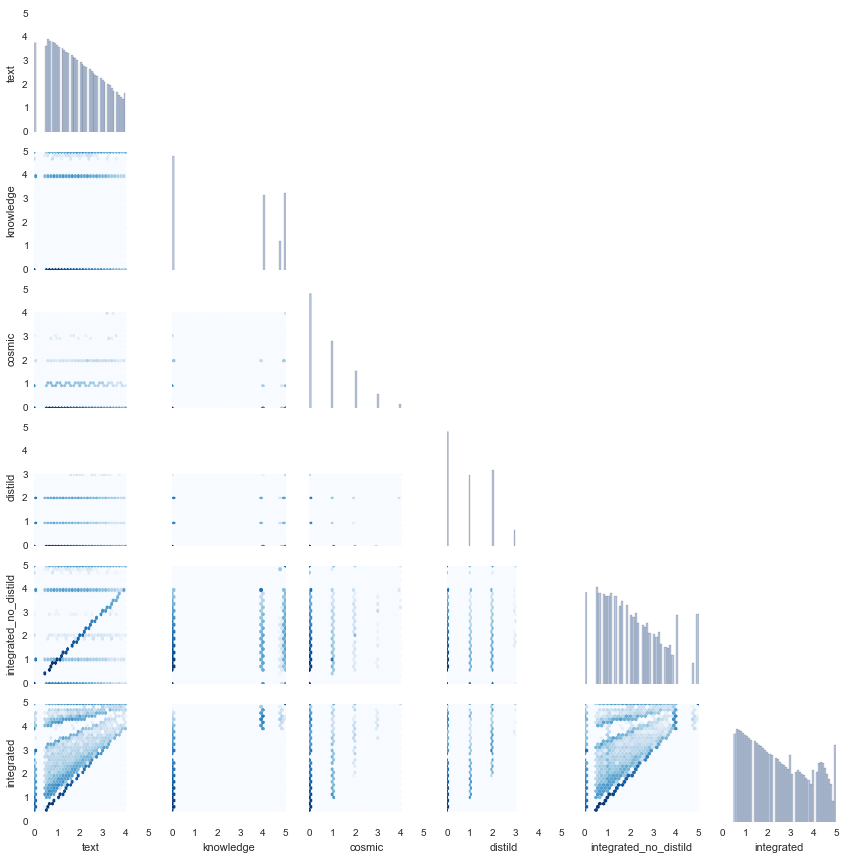

In [27]:
seaborn.set_style('white')
viz_df = master_df.iloc[:, 4:].fillna(0)
viz_df.columns = viz_df.columns.map(lambda x: x.split('_', 1)[1])
grid = seaborn.PairGrid(viz_df, size=2)
grid.map_diag(seaborn.distplot, kde=False, hist_kws={'log': True})
grid.map_lower(matplotlib.pyplot.hexbin, bins='log', cmap='Blues', gridsize=30, linewidths=0)
grid.set(xlim=(0, 5), ylim=(0, 5))
seaborn.despine(top=True, right=True, left=True, bottom=True)
grid.savefig('figure/channel-histograms.png', dpi=300)

In [23]:
len(master_df)

698414

In [24]:
sum(master_df.score_integrated_no_distild >= 3)

22594

## DO Slim conversion

In [25]:
master_slim_df = doslim_prop_df.merge(master_df)
master_slim_df = master_slim_df.groupby(['slim_id', 'entrez_gene_id'])[['score_' + x[1] for x in renames]].max().reset_index()
master_slim_df = master_slim_df.rename(columns={'slim_id': 'doid_id'})
master_slim_df = doid_df.merge(entrez_df.merge(master_slim_df))
master_slim_df.head(2)

,doid_id,doid_name,entrez_gene_id,gene_symbol,score_text,score_knowledge,score_cosmic,score_distild,score_integrated_no_distild,score_integrated
0,DOID:13223,uterine fibroid,60,ACTB,0.8,NaN,NaN,NaN,0.8,0.8
1,DOID:13223,uterine fibroid,71,ACTG1,0.8,NaN,NaN,NaN,0.8,0.8


In [26]:
master_slim_df.to_csv('data/merged-slim.tsv', sep='\t', index=False, float_format='%.2g')